# Setup

In [3]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [4]:
%matplotlib inline 

In [5]:
import matplotlib.pyplot as plt
import torch

from bliss.inference import SDSSFrame
from bliss.datasets import sdss
from bliss.inference import reconstruct_scene_at_coordinates
from case_studies.sdss_galaxies.plots.main import load_models


from astropy.table import Table

import plotly.express as px
import plotly.graph_objects as go

Global seed set to 40


In [7]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

5


# Get Config

In [ ]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../../config"):
    cfg = compose("config", overrides=[])
    

# Run

In [ ]:
from bliss.datasets.galsim_galaxies import SingleGalsimGalaxies

In [ ]:
prior = instantiate(cfg.models.prior)

In [ ]:
tile_cat = prior.sample_prior(1, 1, 1, 1)

In [ ]:
tile_cat

In [ ]:
dl = ds.val_dataloader()
for x in dl:
    print(x['images'].shape)

In [ ]:
for x in dl:
    print(x['images'].shape)

In [ ]:
# Load data

# load sdss data
sdss_dir = '/home/imendoza/bliss/data/sdss/'
pixel_scale = 0.393
coadd_file = "/home/imendoza/bliss/data/coadd_catalog_94_1_12.fits"
frame = SDSSFrame(sdss_dir, pixel_scale, coadd_file)

# Encoder blend images

In [8]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../../config"):
    cfg = compose("config", overrides=[])
    
    
enc, dec = load_models(cfg, device)
bp = enc.border_padding
torch.cuda.empty_cache()

In [9]:
enc.n_rows_per_batch = 10
enc.n_images_per_batch = 15

In [10]:
blend_images = torch.load('../../models/simulated_blended_galaxies.pt')
blend_images['images'].shape

torch.Size([10240, 1, 81, 81])

In [11]:
n_images, c, slen, _ = blend_images['images'].shape
background = blend_images['background']
background = background.unsqueeze(0)
background = background.expand(n_images, 1, slen, slen)

In [17]:
tile_map = enc.variational_mode(blend_images['images'], background)

Encoding ptiles: 683it [00:41, 16.38it/s]


In [16]:
torch.randn(10, 2, 3, 1, 3).shape[-3:]

torch.Size([3, 1, 3])

In [22]:
full = tile_map.to_full_params()

In [25]:
print(full.plocs.shape)
print(full.n_sources.max().item())

torch.Size([10240, 6, 2])
6


3 2


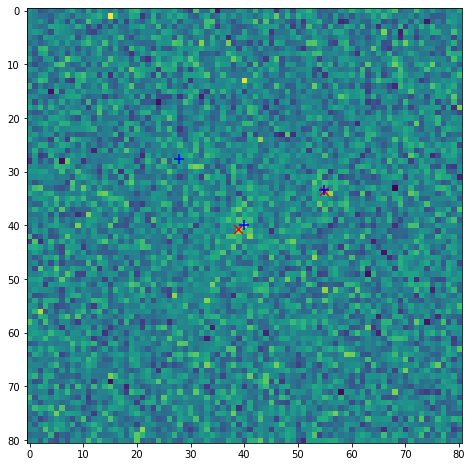

In [34]:
ii = 8
plt.figure(figsize=(8, 8))
plt.imshow(blend_images['images'][ii].cpu().numpy().reshape(slen, slen))
plocs = full.plocs[ii, :full.n_sources[ii].item()].cpu().numpy()
plt.scatter(plocs[:, 1] - 0.5 + enc.border_padding, plocs[:, 0] - 0.5 + enc.border_padding, marker='x', 
            color='r', s=75)
true_plocs = blend_images['plocs'][ii].cpu().numpy()
plt.scatter(true_plocs[:, 1] - 0.5, true_plocs[:, 0] - 0.5, marker='+', 
            color='b', s=100)
print(blend_images['n_sources'][ii].item(), full.n_sources[ii].item())